# Image classification (Rock, Scissor, Paper)

## 1. 데이터 불러오기
전에 Exploration_1에서 실습했던 숫자 손글씨는 이미지 크기가 28x28이었기 때문에,
설계된 모델에 맞추려면 가위바위보 이미지도 28x28로 만들어줘야 한다.

In [1]:
# PIL 라이브러리 블러오기
from PIL import Image
import os, glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 1-1. 가위바위보 이미지 크기 변환


In [2]:
# 이미지 크기 변환 함수
import os

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [3]:
# 모든 가위 이미지 변환 (train dataset 사용)

# 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [4]:
# 모든 바위 이미지 변환 (train dataset 사용)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [5]:
# 모든 보 이미지 변환 (train dataset 사용)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


## 2. 데이터 전처리
### 2-1. 불러오기
숫자 손글씨 인식기에서는 mnist.load_data()라는 함수로 데이터를 불러왔음.
여기서는 load_data() 함수를 만들어서 데이터를 불러오도록 하자!

In [6]:
# load_data() 함수
# 입력으로 이미지가 있는 폴더 위치를 받는다
# 숫자 손글씨 인식기와는 다르게 10개의 클래스 (0~9)가 아닌 3개의 클래스 (가위:0, 바위:1, 보:2)이다.
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train"
(x_train, y_train)=load_data(image_dir_path)

# 데이터 파악하기
print(x_train.shape)
print(y_train.shape)
# **** 숫자 손글씨 이미지와 같이 0~255의 픽셀 값을 가진다?? ****
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

학습데이터(x_train)의 이미지 개수는 300 입니다.
(300, 28, 28, 3)
(300,)
최소값: 0  최대값: 255


In [7]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
최소값: 0.0  최대값: 1.0


라벨:  0


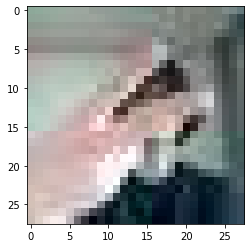

In [8]:
# 이미지를 한번 불러와 보자
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 3. 딥러닝 네트워크 설계

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
# [[YOUR CODE]]
# 처음은 숫자 손글씨 이미지 때와 비슷하게 간다. **** 마지막 Dense만 3으로 바꿈 ****

n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 결과적으로 분류해 내야 하는 클래스: 3개!

print('Model에 추가된 Layer 개수: ', len(model.layers))

#딥러닝 네트워크 확인
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (No

## 4. 딥러닝 네트워크 학습

In [10]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 [==============================] - 5s 191ms/step - loss: 1.1047 - accuracy: 0.3697
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0509 - accuracy: 0.4206
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9797 - accuracy: 0.6125
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9137 - accuracy: 0.5932
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8527 - accuracy: 0.6369
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.8381
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.7782
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5354 - accuracy: 0.8705
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4568 - accuracy: 0.8933
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3533 - accuracy: 0.9465


## 5. 모델 테스트

### 5-1. 테스트용 데이터 불러오기

In [14]:
def load_data_test(img_path, number_of_data=1797):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs_test=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels_test=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/scissors_complete/*.jpg'):
        img_test = np.array(Image.open(file),dtype=np.int32)
        imgs_test[idx,:,:,:]=img_test    # 데이터 영역에 이미지 행렬을 복사
        labels_test[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/rocks_complete/*.jpg'):
        img_test = np.array(Image.open(file),dtype=np.int32)
        imgs_test[idx,:,:,:]=img_test    # 데이터 영역에 이미지 행렬을 복사
        labels_test[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/papers_complete/*.jpg'):
        img_test = np.array(Image.open(file),dtype=np.int32)
        imgs_test[idx,:,:,:]=img_test    # 데이터 영역에 이미지 행렬을 복사
        labels_test[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs_test, labels_test

image_dir_path_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data_test(image_dir_path_test)

# 데이터 파악하기
print(x_test.shape)
print(y_test.shape)
# **** 숫자 손글씨 이미지와 같이 0~255의 픽셀 값을 가진다?? ****
print('최소값:',np.min(x_test), ' 최대값:',np.max(x_test))

학습데이터(x_train)의 이미지 개수는 1797 입니다.
(1797, 28, 28, 3)
(1797,)
최소값: 0  최대값: 255


In [15]:
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))
print('최소값:',np.min(x_test_norm), ' 최대값:',np.max(x_test_norm))

x_train shape: (1797, 28, 28, 3)
y_train shape: (1797,)
최소값: 0.0  최대값: 1.0


라벨:  0


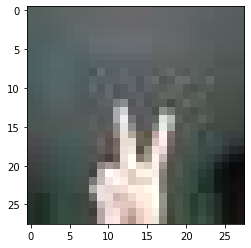

In [16]:
# 이미지를 한번 불러와 보자
import matplotlib.pyplot as plt
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

### 5-2. 테스트용 데이터로 성능 확인하기

In [17]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

57/57 - 1s - loss: 1.3006 - accuracy: 0.3072
test_loss: 1.3006423711776733 
test_accuracy: 0.3071786165237427


## 6. 더 좋은 네트워크 만들기

### 6-1. 하이퍼 파라미터 바꾸기
1. Conv2D layer (입력 이미지의 특징 수) 바꾸기
2. Dense layer (뉴런 수) 바꾸기
3. epoch (학습 반복 횟수) 바꾸기

In [19]:
n_channel_1=64
n_channel_2=128
n_dense=128
n_train_epoch=100


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 결과적으로 분류해 내야 하는 클래스: 3개!

print('Model에 추가된 Layer 개수: ', len(model.layers))

# 딥러닝 네트워크 확인
model.summary()

# 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch) 

# 5. 테스트
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model에 추가된 Layer 개수:  7
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_5 (Dense)              (

10/10 [==============================] - 0s 4ms/step - loss: 4.7295e-05 - accuracy: 1.0000
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 4.3737e-05 - accuracy: 1.0000
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 4.1600e-05 - accuracy: 1.0000
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 4.2224e-05 - accuracy: 1.0000
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 3.8240e-05 - accuracy: 1.0000
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 3.9297e-05 - accuracy: 1.0000
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 3.7300e-05 - accuracy: 1.0000
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 3.6429e-05 - accuracy: 1.0000
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 3.3378e-05 - accuracy: 1.0000
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 3.4

### 6-2. train과 test data 바꿔보기
 - train dataset이 너무 작음

In [20]:
n_channel_1=64
n_channel_2=128
n_dense=128
n_train_epoch=100


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 결과적으로 분류해 내야 하는 클래스: 3개!

print('Model에 추가된 Layer 개수: ', len(model.layers))

# 딥러닝 네트워크 확인
model.summary()

# 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_test_norm, y_test, epochs=n_train_epoch) 

# 5. 테스트
test_loss, test_accuracy = model.evaluate(x_train_norm, y_train, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model에 추가된 Layer 개수:  7
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_7 (Dense)              (

57/57 [==============================] - 0s 4ms/step - loss: 3.8248e-05 - accuracy: 1.0000
Epoch 69/100
57/57 [==============================] - 0s 4ms/step - loss: 3.6456e-05 - accuracy: 1.0000
Epoch 70/100
57/57 [==============================] - 0s 4ms/step - loss: 3.4584e-05 - accuracy: 1.0000
Epoch 71/100
57/57 [==============================] - 0s 4ms/step - loss: 3.6564e-05 - accuracy: 1.0000
Epoch 72/100
57/57 [==============================] - 0s 4ms/step - loss: 2.8789e-05 - accuracy: 1.0000
Epoch 73/100
57/57 [==============================] - 0s 4ms/step - loss: 3.0450e-05 - accuracy: 1.0000
Epoch 74/100
57/57 [==============================] - 0s 4ms/step - loss: 2.5640e-05 - accuracy: 1.0000
Epoch 75/100
57/57 [==============================] - 0s 4ms/step - loss: 2.8736e-05 - accuracy: 1.0000
Epoch 76/100
57/57 [==============================] - 0s 4ms/step - loss: 2.6299e-05 - accuracy: 1.0000
Epoch 77/100
57/57 [==============================] - 0s 4ms/step - loss: 2.6